In [59]:
import cellrank as cr
import scanpy as sc
import scvelo as scv
from cellrank.kernels import VelocityKernel
from cellrank.estimators import GPCCA
import numpy as np
import matplotlib.pyplot as plt

In [60]:
adata = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/adata_gex_velocities.h5ad")
adata.obsm["X_pca"] = adata.layers["X_pca"].copy()
adata.layers["velocity"] = adata.layers["GEX_velocity"].copy()
sc.pp.neighbors(adata, use_rep="X_pca")
scv.tl.umap(adata)
adata.X = np.ones((20519,50))

In [61]:
vk = VelocityKernel(adata, xkey="X_pca", vkey="GEX_velocity").compute_transition_matrix()

100%|████████████████████████████████████████████████████████████████████████████████| 20519/20519 [00:04<00:00, 4914.30cell/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
100%|████████████████████████████████████████████████████████████████████████████████| 20519/20519 [00:04<00:00, 5026.52cell/s]


In [62]:
vk.adata

AnnData object with n_obs × n_vars = 20519 × 50
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final', 'celltype', 'prolif', 'apoptosis', 'growth_rate', 'scaled_growth_rate', 'scaled3_growth_rate', 'scaled4_growth_rate'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'GEX_velocity', 'X_pca', 'velocity'
    obsp: 'distances', 'connectivities'

In [63]:
g = GPCCA(vk)

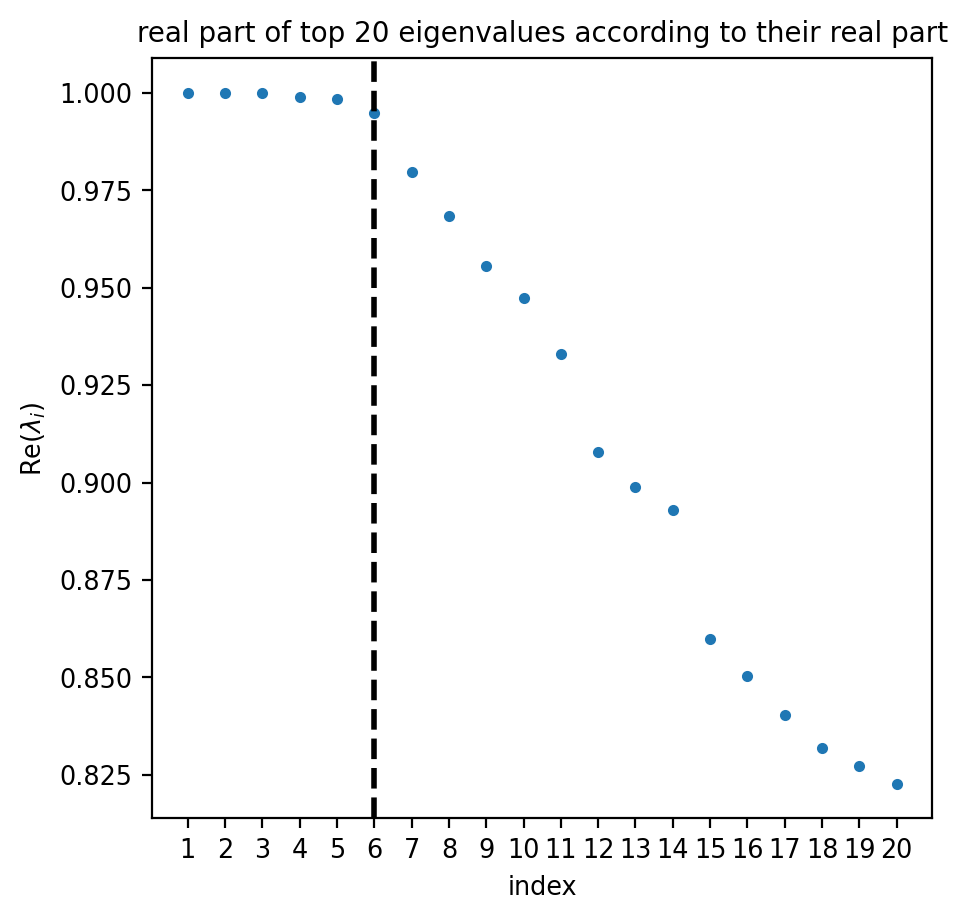

In [64]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

In [65]:
results = {}

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


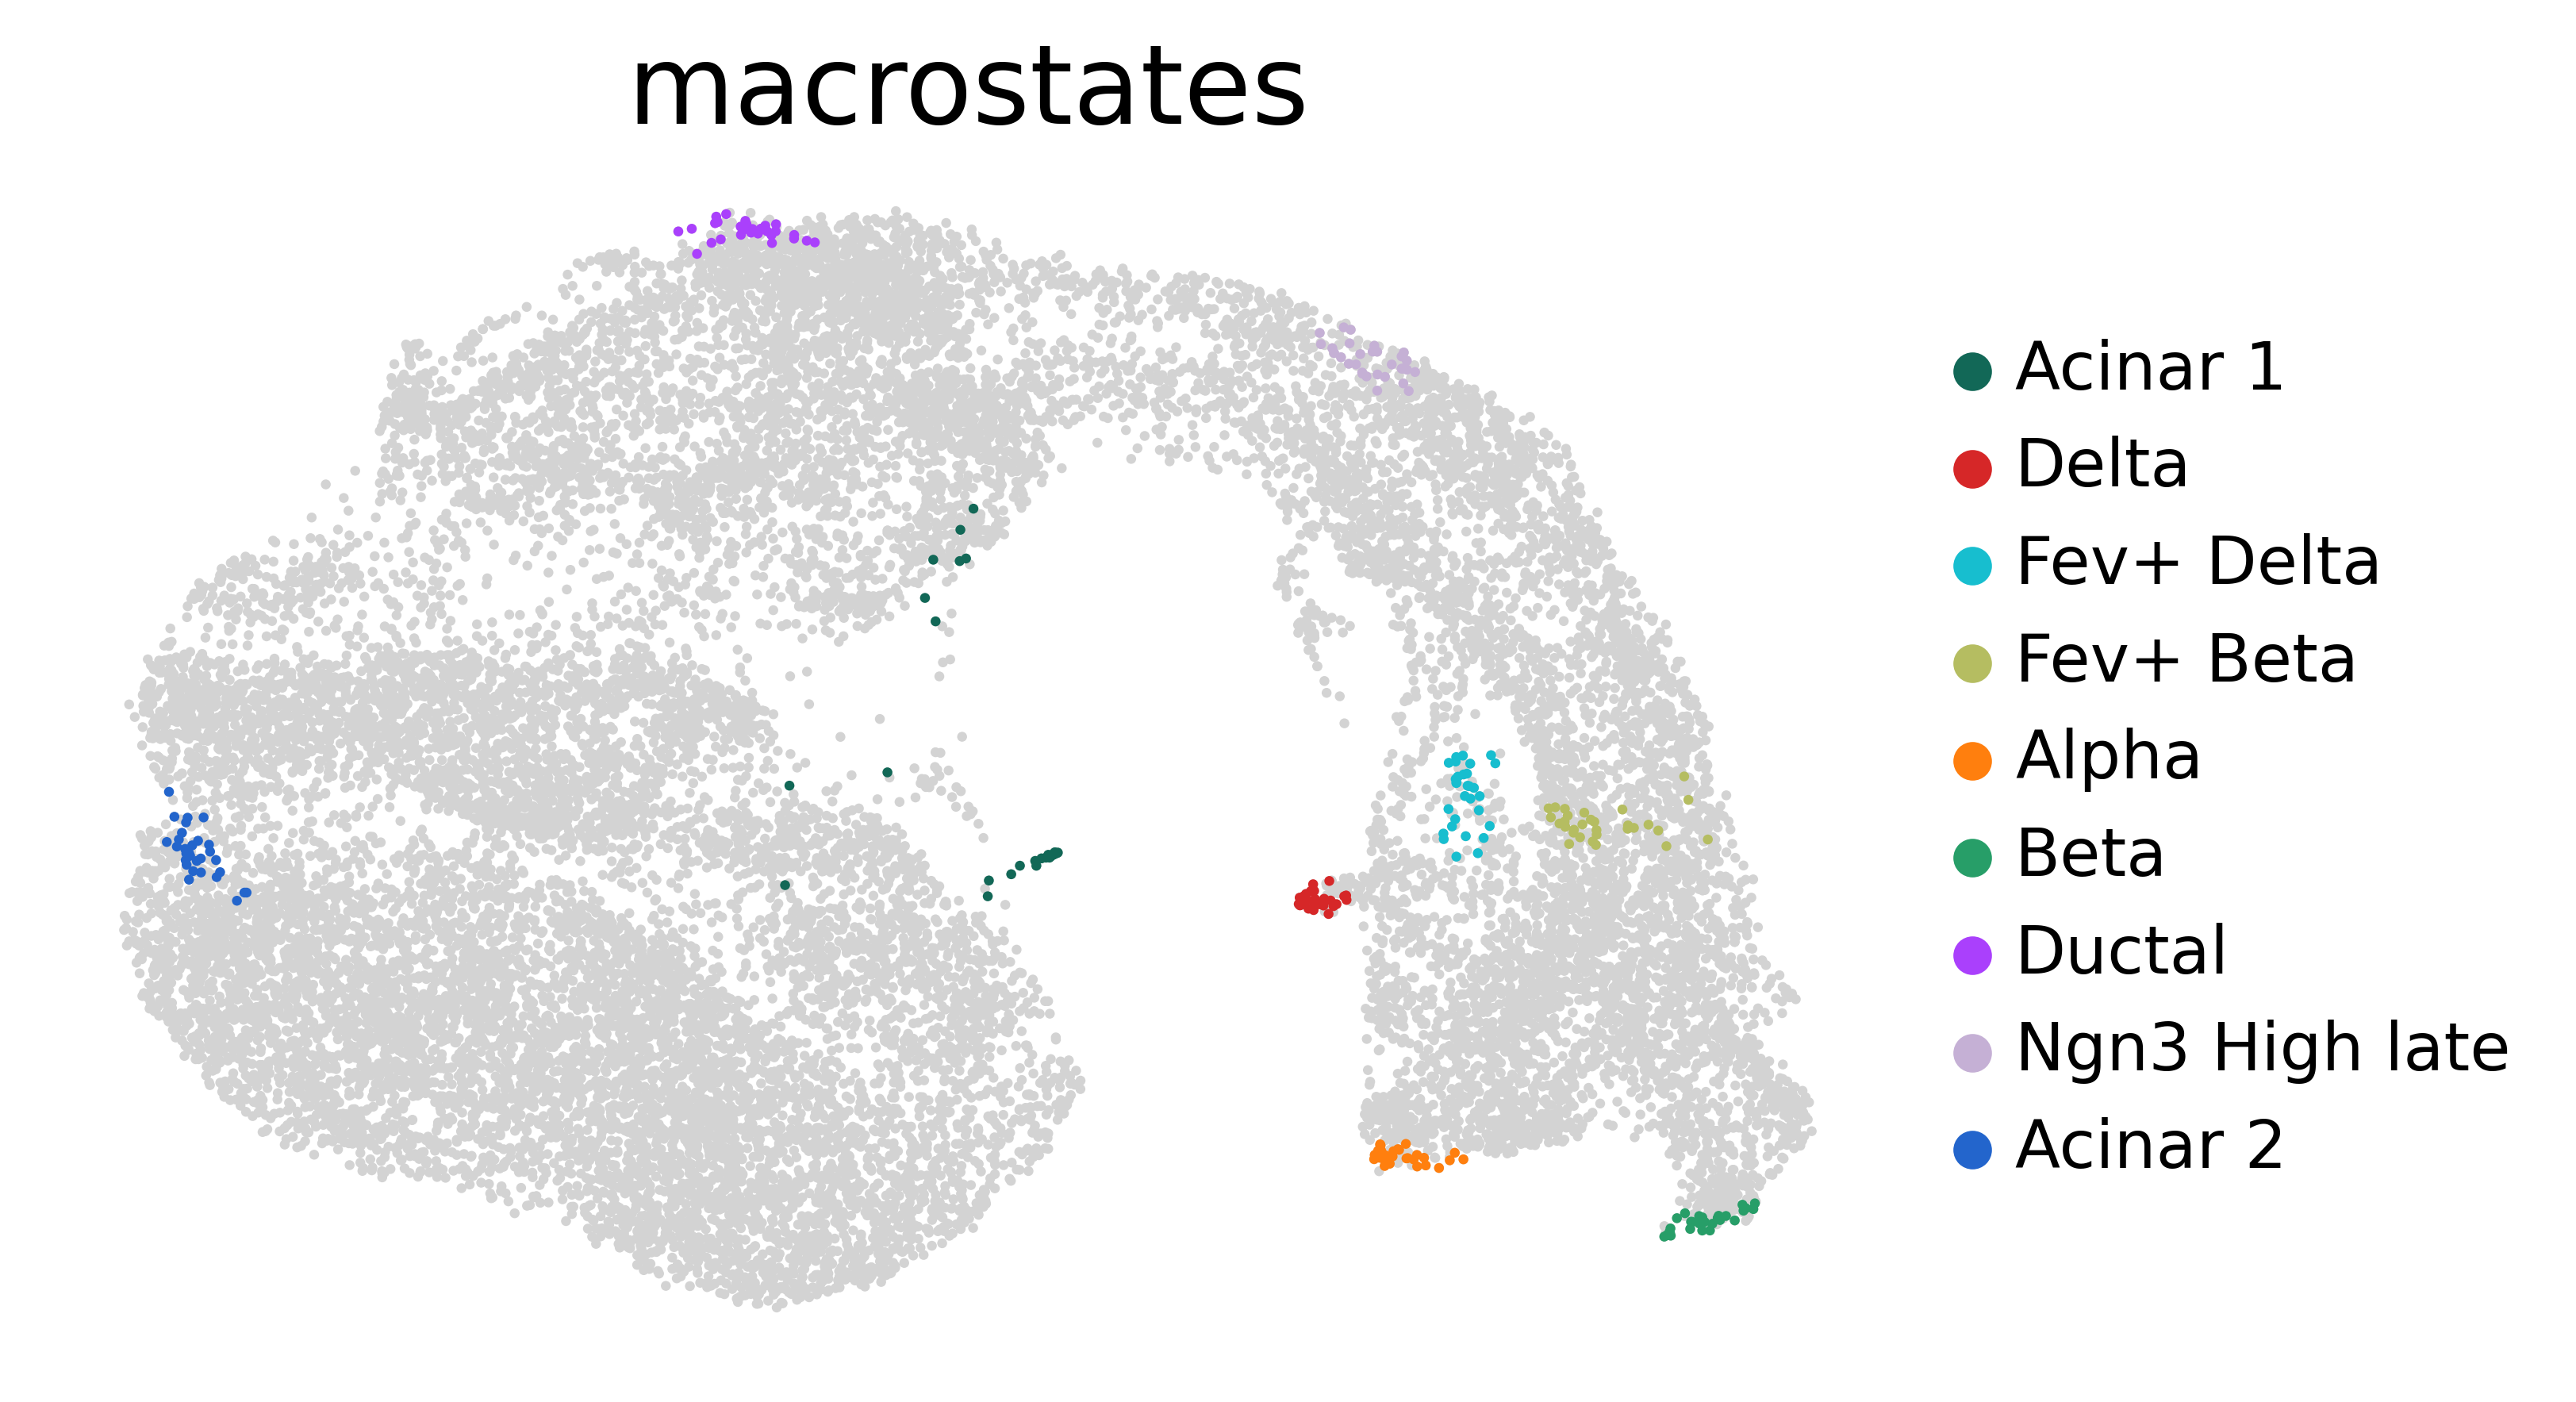

In [66]:
g.compute_macrostates(n_states=9, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


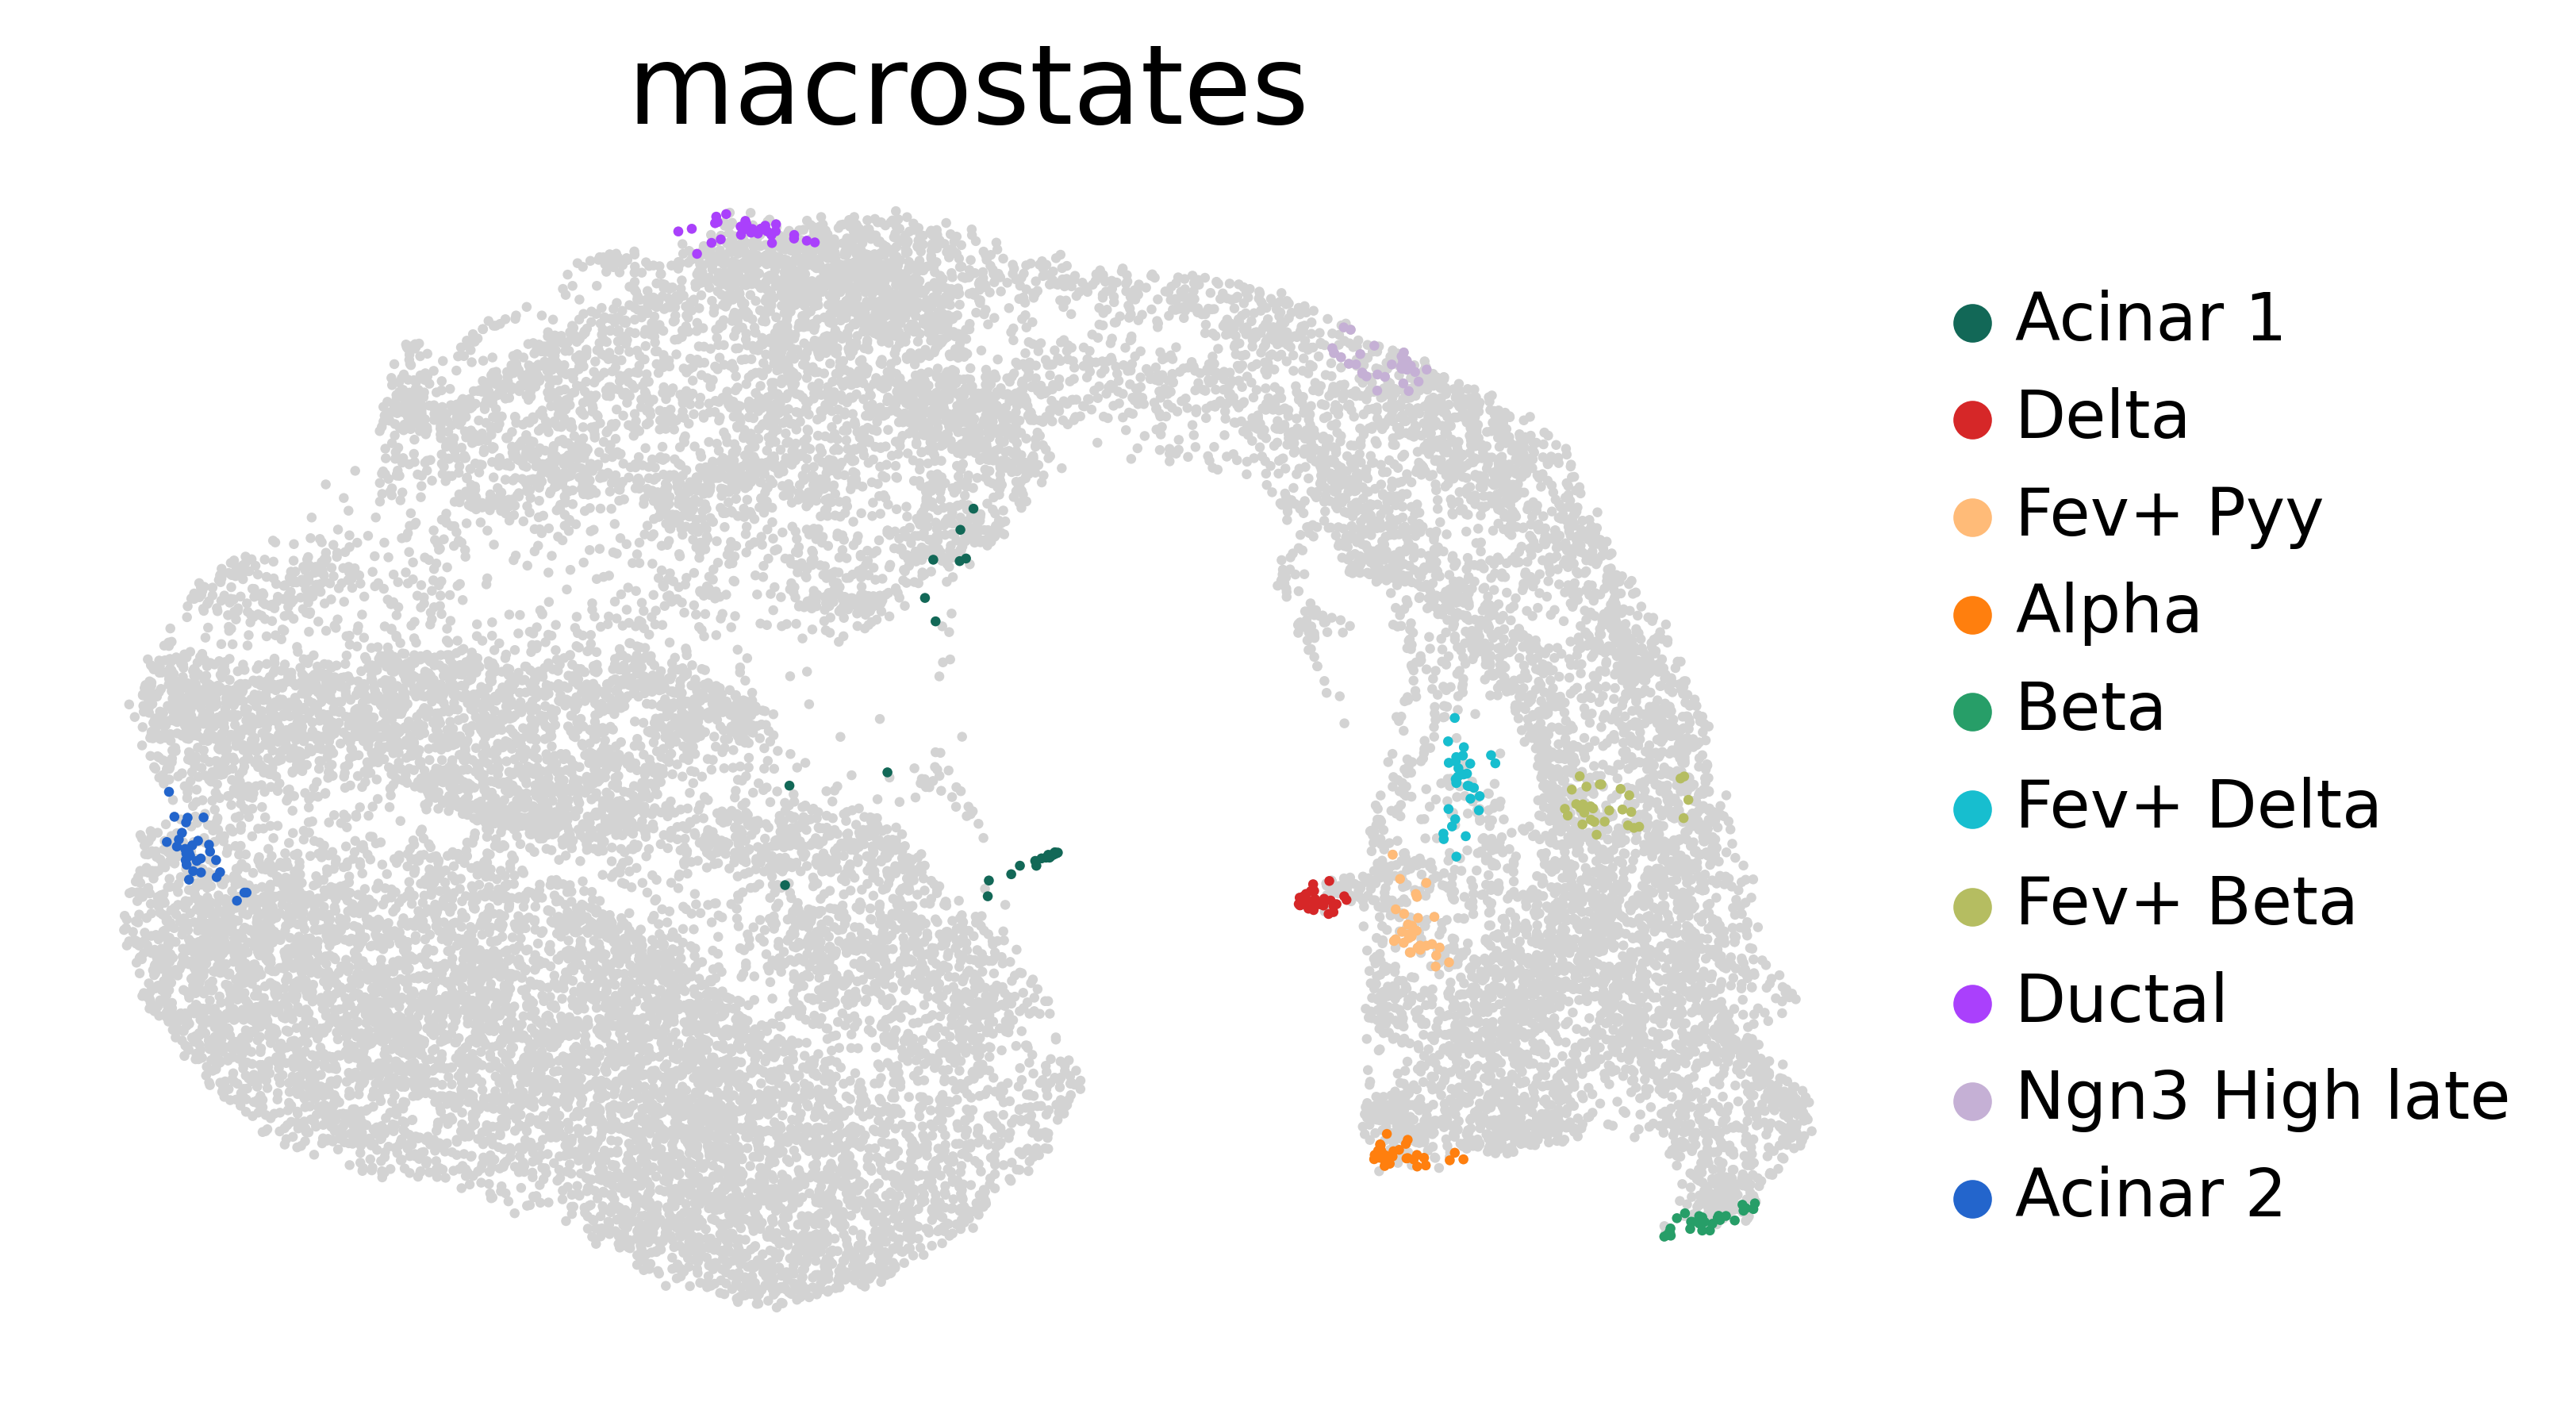

In [67]:
g.compute_macrostates(n_states=10, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [68]:
results['consistency'] = 3

In [69]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar_1", "Acinar_2", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

KeyError: "Invalid lineage name `'Epsilon'`. Valid names are: `['Acinar_1', 'Delta', 'Fev+ Pyy', 'Alpha', 'Beta', 'Fev+ Delta', 'Fev+ Beta', 'Ductal', 'Ngn3 High late', 'Acinar_2']`."

In [ ]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar_1", "Acinar_2", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 7),
    title="",
    #save="transprobs_wot.png"
)

In [ ]:
cluster = ['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon']
terminal_cluster = ["Acinar_1", "Acinar_2", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"]

aggregated_absorption_prob = np.empty((len(terminal_cluster), len(cluster)))
data = g.absorption_probabilities.X
sums = np.sum(data, axis=0)
tmp = adata.obs['celltype']

for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = np.dot(np.array((tmp.array==cluster[i]).astype(int)),data)
for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = aggregated_absorption_prob[:,i]/np.sum(aggregated_absorption_prob[:,i])

In [ ]:
correct_transitions = [('Acinar_1', 'Acinar'), ('Acinar_2', 'Acinar'), ('Acinar_1', 'Tip'), ('Acinar_2', 'Tip'), 
                       ('Acinar_1', 'Multipotent'), ('Acinar_2', 'Multipotent'),
                       ('Ductal', 'Ductal'), ('Ductal_2', 'Ductal'), ('Ductal_3', 'Ductal'),
                       ('Ductal_1', 'Multipotent'), ('Ductal_2', 'Multipotent'), ('Ductal_3', 'Multipotent'),
                       ('Alpha', 'Alpha'), ('Alpha', 'Fev+ Beta'), ('Alpha', 'Fev+ Delta'),
                       ('Alpha', 'Fev+ Alpha'), ('Alpha', 'Fev+ Epsilon'), ('Alpha', 'Ngn3 High early'),
                       ('Alpha', 'Ngn3 High late'), ('Beta', 'Beta'), ('Beta', 'Fev+ Beta'), ('Beta', 'Fev+ Delta'),
                       ('Beta', 'Fev+ Alpha'), ('Beta', 'Fev+ Epsilon'), ('Beta', 'Ngn3 High early'), 
                       ('Beta', 'Ngn3 High late'), ('Delta', 'Delta'), ('Delta', 'Fev+ Beta'), 
                       ('Delta', 'Fev+ Delta'), ('Delta', 'Fev+ Alpha'), ('Delta', 'Fev+ Epsilon'),
                       ('Delta', 'Ngn3 High early'), ('Delta', 'Ngn3 High late'), ('Epsilon', 'Epsilon'), 
                       ('Epsilon', 'Fev+ Beta'), ('Epsilon', 'Fev+ Delta'), ('Epsilon', 'Fev+ Alpha'), 
                       ('Epsilon', 'Fev+ Epsilon'), ('Epsilon', 'Ngn3 High early'), ('Epsilon', 'Ngn3 High late'), 
                       ('Alpha', 'Multipotent'),('Epsilon', 'Multipotent'), ('Beta', 'Multipotent'), 
                       ('Delta', 'Multipotent')]

sum_prob = 0
for i in correct_transitions:
    sum_prob = sum_prob + df.loc[i]
mean_prob = sum_prob/len(cluster)
mean_prob

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 600x400 with 0 Axes>

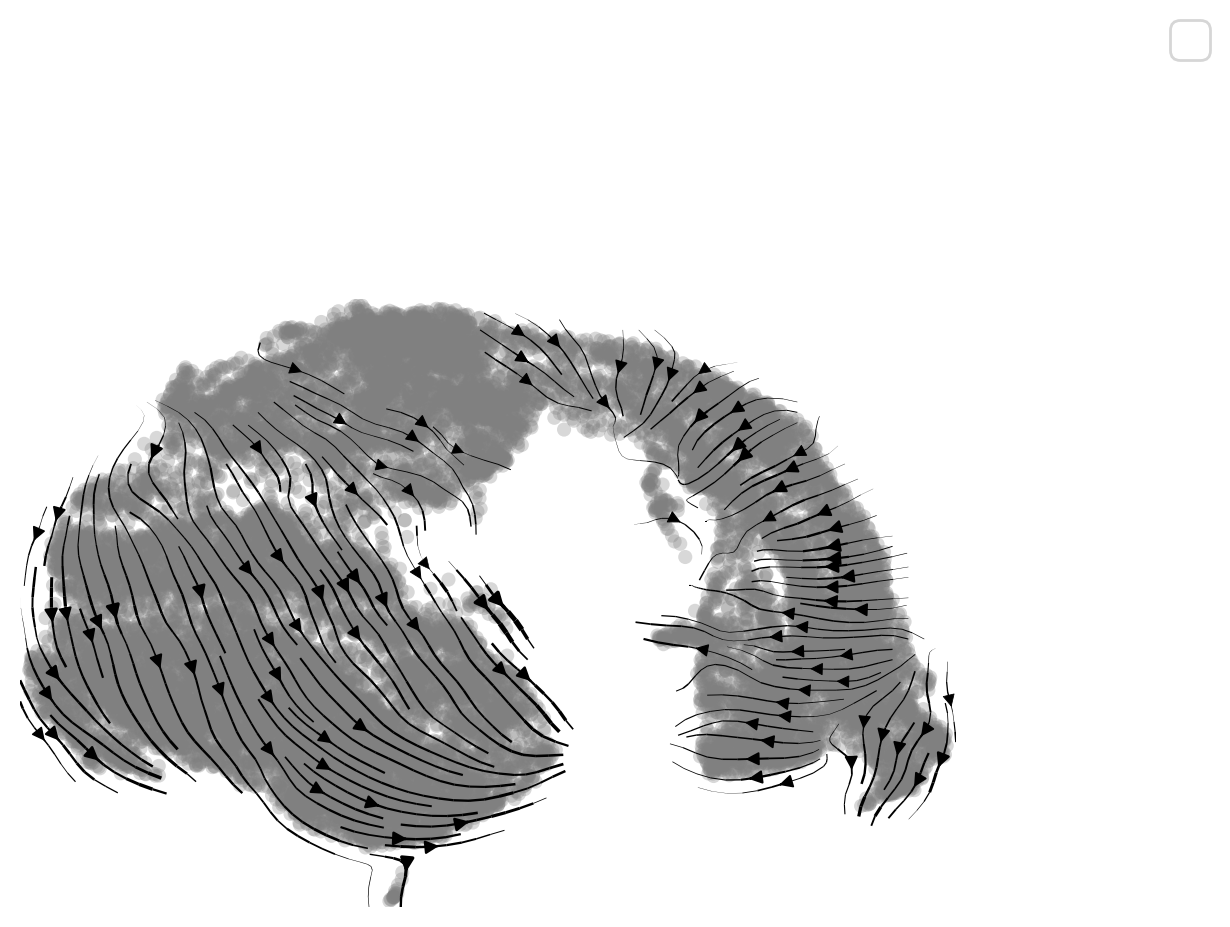

In [13]:
adata.uns["velocity_graph"] = vk.transition_matrix

scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="umap", smooth=0.5, title="", legend_loc="none", show=False)
legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})
#plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')